In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
import copy

In [2]:
batch_size = 64
num_epochs = 30
early_stop_patience = 5
data_dir = "../data/animals10"

In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(root=os.path.join(data_dir, "train"), transform=transform)
test_dataset = datasets.ImageFolder(root=os.path.join(data_dir, "test"), transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.alexnet(pretrained=False)
model.classifier[6] = nn.Linear(4096, len(train_dataset.classes))
model.to(device)

def init_weights(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

model.apply(init_weights)

# for param in model.parameters():
#     param.requires_grad = True

C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

train_losses, test_losses, train_accs, test_accs = [], [], [], []
best_loss = float('inf')
patience = 0
best_epoch = 0
best_model = None

for epoch in range(num_epochs):
    model.train()
    total, correct, train_loss = 0, 0, 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        correct += (out.argmax(1) == y).sum().item()
        total += y.size(0)

    acc = correct / total
    train_losses.append(train_loss / len(train_loader))
    train_accs.append(acc)

    model.eval()
    total, correct, val_loss = 0, 0, 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            val_loss += criterion(out, y).item()
            correct += (out.argmax(1) == y).sum().item()
            total += y.size(0)

    val_acc = correct / total
    test_losses.append(val_loss / len(test_loader))
    test_accs.append(val_acc)

    print(f"Epoch {epoch+1:02d} | Train Loss: {train_losses[-1]:.4f} | Test Loss: {test_losses[-1]:.4f} | Train Acc: {acc:.4f} | Test Acc: {val_acc:.4f}")

    if test_losses[-1] < best_loss:
        best_loss = test_losses[-1]
        best_model = copy.deepcopy(model.state_dict())
        best_epoch = epoch + 1
        patience = 0
    else:
        patience += 1
        if patience >= early_stop_patience:
            print(f"\n🛑 Early stopping triggered at epoch {epoch+1}. Best model was from epoch {best_epoch}.")
            break


Epoch 01 | Train Loss: 1.8404 | Test Loss: 1.4160 | Train Acc: 0.3490 | Test Acc: 0.5083
Epoch 02 | Train Loss: 1.3313 | Test Loss: 1.1925 | Train Acc: 0.5389 | Test Acc: 0.5930
Epoch 03 | Train Loss: 1.1047 | Test Loss: 1.0559 | Train Acc: 0.6196 | Test Acc: 0.6432
Epoch 04 | Train Loss: 0.9417 | Test Loss: 0.9782 | Train Acc: 0.6770 | Test Acc: 0.6541
Epoch 05 | Train Loss: 0.8304 | Test Loss: 0.8487 | Train Acc: 0.7147 | Test Acc: 0.7157
Epoch 06 | Train Loss: 0.7107 | Test Loss: 0.8704 | Train Acc: 0.7561 | Test Acc: 0.7100
Epoch 07 | Train Loss: 0.6234 | Test Loss: 0.7928 | Train Acc: 0.7862 | Test Acc: 0.7390
Epoch 08 | Train Loss: 0.5285 | Test Loss: 0.8177 | Train Acc: 0.8191 | Test Acc: 0.7436
Epoch 09 | Train Loss: 0.4508 | Test Loss: 0.7566 | Train Acc: 0.8425 | Test Acc: 0.7588
Epoch 10 | Train Loss: 0.3746 | Test Loss: 0.7988 | Train Acc: 0.8705 | Test Acc: 0.7634
Epoch 11 | Train Loss: 0.3093 | Test Loss: 0.8013 | Train Acc: 0.8924 | Test Acc: 0.7596
Epoch 12 | Train Loss

In [6]:
if best_model is not None:
    model.load_state_dict(best_model)
    
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        correct += (out.argmax(1) == y).sum().item()
        total += y.size(0)

print(f"\n✅ Final Test Accuracy: {correct / total:.4f}")


✅ Final Test Accuracy: 0.7588


In [7]:
from sklearn.metrics import classification_report

# Calcular predicciones y etiquetas verdaderas
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        outputs = model(x)
        preds = outputs.argmax(1).cpu()
        all_preds.extend(preds.numpy())
        all_labels.extend(y.numpy())

# Imprimir reporte de clasificación
print("\n📊 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes if hasattr(test_dataset, 'classes') else [str(i) for i in range(10)]))



📊 Classification Report:
              precision    recall  f1-score   support

   butterfly       0.81      0.86      0.84       423
         cat       0.62      0.50      0.56       334
     chicken       0.77      0.86      0.81       620
         cow       0.70      0.70      0.70       374
         dog       0.71      0.79      0.75       973
    elephant       0.73      0.72      0.72       290
       horse       0.83      0.71      0.76       525
       ragno       0.89      0.86      0.87       965
       sheep       0.81      0.54      0.65       364
    squirrel       0.61      0.72      0.66       373

    accuracy                           0.76      5241
   macro avg       0.75      0.73      0.73      5241
weighted avg       0.76      0.76      0.76      5241



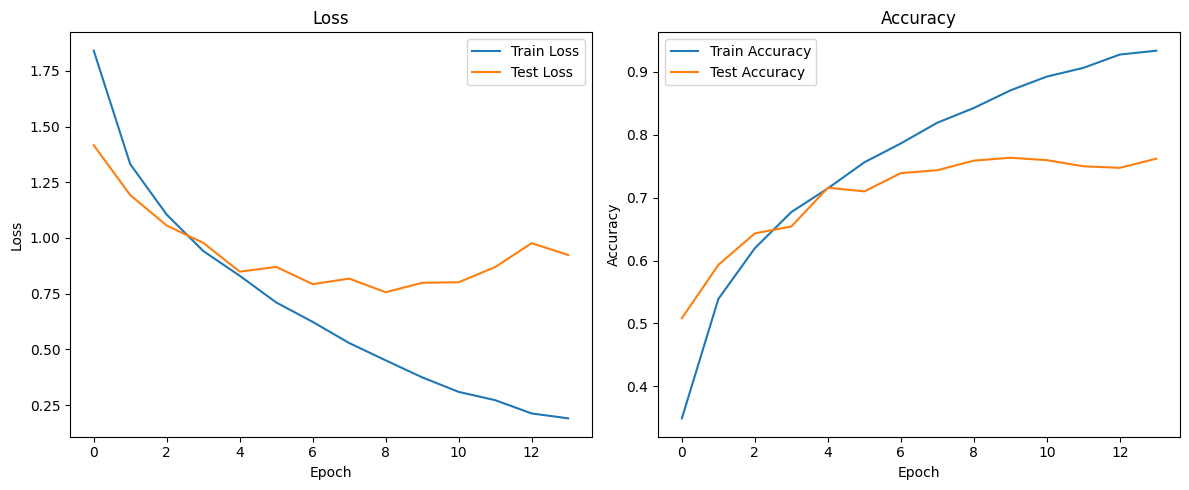

In [8]:
# Gráficas
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train Accuracy")
plt.plot(test_accs, label="Test Accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [9]:
print(train_losses)
print(test_losses)
print(train_accs)
print(test_accs)

[1.8403844411780195, 1.331302139998936, 1.1046541451317509, 0.94167095822532, 0.8304036801181188, 0.710670069223497, 0.6233971525074505, 0.5285236975405274, 0.45082717756854324, 0.37457609908064693, 0.3093301943253453, 0.2721624989744003, 0.21249354015127186, 0.19056840307965148]
[1.4160339795961612, 1.1924602214883013, 1.0558833636161757, 0.9782005341314688, 0.8487394590203355, 0.8703545253814721, 0.7927736391018076, 0.8176918816639156, 0.7565737348504182, 0.7988281488055136, 0.8013363565977026, 0.8695043727028661, 0.9766071791329035, 0.9236853592915506]
[0.3490304709141274, 0.5388766835418856, 0.6195911739421148, 0.6770465182921005, 0.7146814404432132, 0.7561371668736269, 0.7861782405196294, 0.8191326774285987, 0.842535103639316, 0.8704747349317031, 0.8924443595376826, 0.9062947750501481, 0.9275002388002674, 0.9336135256471487]
[0.5082999427590155, 0.593016599885518, 0.6431978630032437, 0.6540736500667812, 0.7157031100934936, 0.7099790116390002, 0.7389811104751002, 0.7435603892386949